# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [40]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

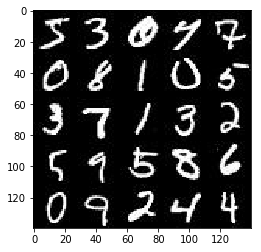

In [41]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

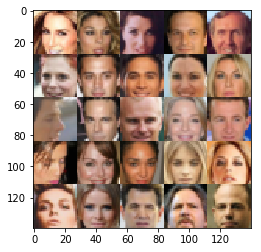

In [42]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [43]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


D:\Anaconda3\envs\tensorflow1.0\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [44]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, 
                                 (None, image_width, image_height, image_channels), 
                                 name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None))
    return inputs_real, inputs_z, learning_rate



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [45]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input is 28 x 28 x 3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)

        # 14 x 14 x 64  
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * x2, x2)
        

        #7 x 7 x 128    
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * x3, x3)

        # 4 x 4 x 256
        flat = tf.reshape(relu3, shape=(-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return (out, logits)
#     x = images
#     with tf.variable_scope('discriminator', reuse=reuse):
#         x = tf.layers.conv2d(x, 64, 4, strides=2, padding="same")
#         x = tf.layers.batch_normalization(x, training=True)
#         x = tf.maximum(alpha * x, x)
#         #x = tf.layers.dropout(x, 0.5)

#         x = tf.layers.conv2d(x, 128, 4, strides=2, padding="same")
#         x = tf.layers.batch_normalization(x, training=True)
#         x = tf.maximum(alpha * x, x)
#         #x = tf.layers.dropout(x, 0.5)

#         x = tf.layers.conv2d(x, 256, 4, strides=2, padding="same")
#         x = tf.layers.batch_normalization(x, training=True)
#         x = tf.maximum(alpha * x, x)
#         #x = tf.layers.dropout(x, 0.5)

#         x = tf.reshape(x, (-1, 4*4*256))
#         logits = tf.layers.dense(x, 1)
#         out = tf.sigmoid(logits)

#     return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [46]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    kinit = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, kernel_initializer=kinit, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # 14x14x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, kernel_initializer=kinit, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        # 28x28x64
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, kernel_initializer=kinit, padding='same')
        # 28x28x3
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [47]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [48]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
            
    return d_opt, g_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [49]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [50]:

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z})

                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 0.6495... Generator Loss: 1.0828
Epoch 1/2... Discriminator Loss: 0.7540... Generator Loss: 0.8052
Epoch 1/2... Discriminator Loss: 0.6300... Generator Loss: 3.8412
Epoch 1/2... Discriminator Loss: 0.7593... Generator Loss: 0.7405
Epoch 1/2... Discriminator Loss: 0.5989... Generator Loss: 1.1012
Epoch 1/2... Discriminator Loss: 0.5425... Generator Loss: 1.5319
Epoch 1/2... Discriminator Loss: 0.7834... Generator Loss: 0.8917
Epoch 1/2... Discriminator Loss: 0.5957... Generator Loss: 2.3186
Epoch 1/2... Discriminator Loss: 0.6007... Generator Loss: 1.1285
Epoch 1/2... Discriminator Loss: 0.5202... Generator Loss: 1.7964


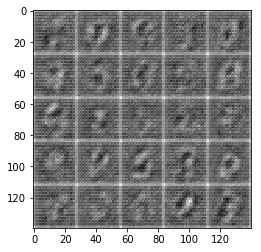

Epoch 1/2... Discriminator Loss: 0.8395... Generator Loss: 2.9420
Epoch 1/2... Discriminator Loss: 1.2609... Generator Loss: 0.4282
Epoch 1/2... Discriminator Loss: 0.5603... Generator Loss: 1.3476
Epoch 1/2... Discriminator Loss: 1.2835... Generator Loss: 3.5154
Epoch 1/2... Discriminator Loss: 0.9105... Generator Loss: 2.5578
Epoch 1/2... Discriminator Loss: 1.0851... Generator Loss: 3.0446
Epoch 1/2... Discriminator Loss: 0.6425... Generator Loss: 1.1107
Epoch 1/2... Discriminator Loss: 1.0489... Generator Loss: 3.0083
Epoch 1/2... Discriminator Loss: 0.5982... Generator Loss: 1.8823
Epoch 1/2... Discriminator Loss: 0.8071... Generator Loss: 2.8529


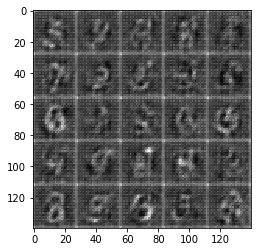

Epoch 1/2... Discriminator Loss: 0.7455... Generator Loss: 2.5610
Epoch 1/2... Discriminator Loss: 1.1333... Generator Loss: 2.8528
Epoch 1/2... Discriminator Loss: 1.1082... Generator Loss: 0.5077
Epoch 1/2... Discriminator Loss: 0.7091... Generator Loss: 0.9214
Epoch 1/2... Discriminator Loss: 0.6642... Generator Loss: 0.9351
Epoch 1/2... Discriminator Loss: 0.6870... Generator Loss: 0.9893
Epoch 1/2... Discriminator Loss: 0.6128... Generator Loss: 1.2447
Epoch 1/2... Discriminator Loss: 0.7813... Generator Loss: 0.8144
Epoch 1/2... Discriminator Loss: 0.7278... Generator Loss: 0.9718
Epoch 1/2... Discriminator Loss: 0.5434... Generator Loss: 1.4150


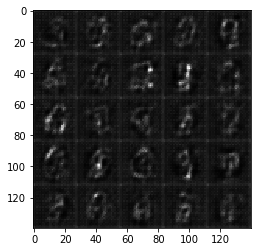

Epoch 1/2... Discriminator Loss: 0.6804... Generator Loss: 2.0737
Epoch 1/2... Discriminator Loss: 0.7326... Generator Loss: 1.7664
Epoch 1/2... Discriminator Loss: 0.5226... Generator Loss: 1.5587
Epoch 1/2... Discriminator Loss: 0.5918... Generator Loss: 1.1982
Epoch 1/2... Discriminator Loss: 0.5152... Generator Loss: 1.4737
Epoch 1/2... Discriminator Loss: 0.5850... Generator Loss: 1.3176
Epoch 1/2... Discriminator Loss: 0.5330... Generator Loss: 1.3549
Epoch 1/2... Discriminator Loss: 0.3815... Generator Loss: 2.0318
Epoch 1/2... Discriminator Loss: 0.6581... Generator Loss: 1.1710
Epoch 1/2... Discriminator Loss: 0.7348... Generator Loss: 0.8672


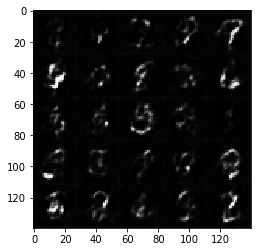

Epoch 1/2... Discriminator Loss: 0.4762... Generator Loss: 1.9046
Epoch 1/2... Discriminator Loss: 0.4729... Generator Loss: 1.7626
Epoch 1/2... Discriminator Loss: 0.4485... Generator Loss: 1.8655
Epoch 1/2... Discriminator Loss: 0.3950... Generator Loss: 1.9449
Epoch 1/2... Discriminator Loss: 0.3606... Generator Loss: 1.9182
Epoch 1/2... Discriminator Loss: 0.4746... Generator Loss: 1.4946
Epoch 1/2... Discriminator Loss: 0.5476... Generator Loss: 1.2036
Epoch 1/2... Discriminator Loss: 0.4971... Generator Loss: 1.5634
Epoch 1/2... Discriminator Loss: 0.4712... Generator Loss: 1.5045
Epoch 1/2... Discriminator Loss: 0.4315... Generator Loss: 1.7214


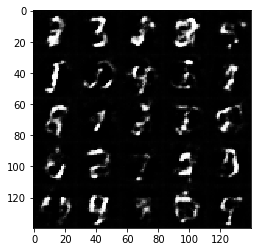

Epoch 1/2... Discriminator Loss: 0.9960... Generator Loss: 0.7186
Epoch 1/2... Discriminator Loss: 0.4873... Generator Loss: 1.4765
Epoch 1/2... Discriminator Loss: 0.4975... Generator Loss: 1.8703
Epoch 1/2... Discriminator Loss: 0.5085... Generator Loss: 1.3474
Epoch 1/2... Discriminator Loss: 0.5139... Generator Loss: 1.5918
Epoch 1/2... Discriminator Loss: 0.8537... Generator Loss: 0.7797
Epoch 1/2... Discriminator Loss: 0.8560... Generator Loss: 0.7659
Epoch 1/2... Discriminator Loss: 0.7584... Generator Loss: 0.7990
Epoch 1/2... Discriminator Loss: 0.7295... Generator Loss: 2.3608
Epoch 1/2... Discriminator Loss: 0.5484... Generator Loss: 1.3127


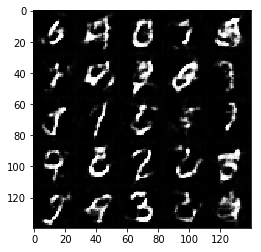

Epoch 1/2... Discriminator Loss: 0.7834... Generator Loss: 0.8619
Epoch 1/2... Discriminator Loss: 1.6043... Generator Loss: 3.6439
Epoch 1/2... Discriminator Loss: 0.6952... Generator Loss: 1.5922
Epoch 1/2... Discriminator Loss: 0.6278... Generator Loss: 1.1027
Epoch 1/2... Discriminator Loss: 0.7788... Generator Loss: 1.8320
Epoch 1/2... Discriminator Loss: 0.8296... Generator Loss: 0.8592
Epoch 1/2... Discriminator Loss: 0.7110... Generator Loss: 1.7381
Epoch 1/2... Discriminator Loss: 0.8149... Generator Loss: 1.4026
Epoch 1/2... Discriminator Loss: 0.6979... Generator Loss: 0.9703
Epoch 1/2... Discriminator Loss: 0.5637... Generator Loss: 1.9419


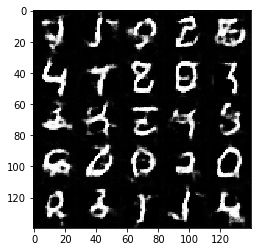

Epoch 1/2... Discriminator Loss: 1.0726... Generator Loss: 0.5791
Epoch 1/2... Discriminator Loss: 1.0743... Generator Loss: 0.5403
Epoch 1/2... Discriminator Loss: 0.9526... Generator Loss: 2.5915
Epoch 1/2... Discriminator Loss: 0.4890... Generator Loss: 1.7533
Epoch 1/2... Discriminator Loss: 0.9006... Generator Loss: 0.6959
Epoch 1/2... Discriminator Loss: 0.5509... Generator Loss: 1.8122
Epoch 1/2... Discriminator Loss: 0.9346... Generator Loss: 0.7789
Epoch 1/2... Discriminator Loss: 1.1116... Generator Loss: 0.5776
Epoch 1/2... Discriminator Loss: 0.7491... Generator Loss: 1.0709
Epoch 1/2... Discriminator Loss: 0.8513... Generator Loss: 0.7847


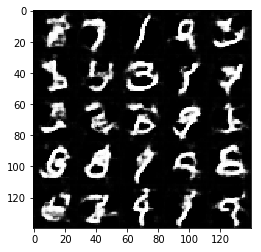

Epoch 1/2... Discriminator Loss: 0.8154... Generator Loss: 2.1169
Epoch 1/2... Discriminator Loss: 0.6122... Generator Loss: 1.4286
Epoch 1/2... Discriminator Loss: 0.6976... Generator Loss: 1.1915
Epoch 1/2... Discriminator Loss: 0.5405... Generator Loss: 1.3322
Epoch 1/2... Discriminator Loss: 0.5294... Generator Loss: 1.3598
Epoch 1/2... Discriminator Loss: 1.2780... Generator Loss: 0.5230
Epoch 1/2... Discriminator Loss: 1.0497... Generator Loss: 2.0682
Epoch 1/2... Discriminator Loss: 0.7358... Generator Loss: 1.3237
Epoch 1/2... Discriminator Loss: 0.6971... Generator Loss: 1.4964
Epoch 1/2... Discriminator Loss: 0.6498... Generator Loss: 1.1648


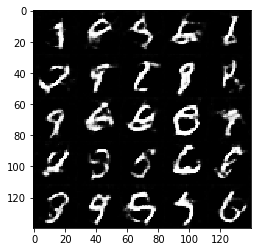

Epoch 1/2... Discriminator Loss: 0.6264... Generator Loss: 1.6372
Epoch 1/2... Discriminator Loss: 0.5809... Generator Loss: 1.5571
Epoch 1/2... Discriminator Loss: 1.1603... Generator Loss: 0.5011
Epoch 2/2... Discriminator Loss: 0.7639... Generator Loss: 0.9240
Epoch 2/2... Discriminator Loss: 0.5551... Generator Loss: 1.7520
Epoch 2/2... Discriminator Loss: 0.6455... Generator Loss: 1.0288
Epoch 2/2... Discriminator Loss: 1.2655... Generator Loss: 0.4718
Epoch 2/2... Discriminator Loss: 0.8000... Generator Loss: 0.8307
Epoch 2/2... Discriminator Loss: 0.9318... Generator Loss: 0.7227
Epoch 2/2... Discriminator Loss: 0.6267... Generator Loss: 1.2536


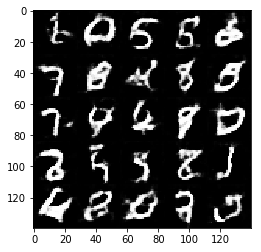

Epoch 2/2... Discriminator Loss: 1.0573... Generator Loss: 0.6334
Epoch 2/2... Discriminator Loss: 0.5402... Generator Loss: 1.4107
Epoch 2/2... Discriminator Loss: 0.7264... Generator Loss: 1.5563
Epoch 2/2... Discriminator Loss: 0.8442... Generator Loss: 1.6619
Epoch 2/2... Discriminator Loss: 0.4994... Generator Loss: 1.6059
Epoch 2/2... Discriminator Loss: 0.9143... Generator Loss: 0.7762
Epoch 2/2... Discriminator Loss: 0.8126... Generator Loss: 0.8884
Epoch 2/2... Discriminator Loss: 0.9951... Generator Loss: 0.6657
Epoch 2/2... Discriminator Loss: 0.7086... Generator Loss: 0.9232
Epoch 2/2... Discriminator Loss: 0.7745... Generator Loss: 0.9446


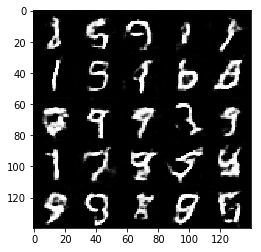

Epoch 2/2... Discriminator Loss: 0.6371... Generator Loss: 1.0464
Epoch 2/2... Discriminator Loss: 0.6559... Generator Loss: 1.4028
Epoch 2/2... Discriminator Loss: 0.5765... Generator Loss: 1.5731
Epoch 2/2... Discriminator Loss: 0.7146... Generator Loss: 1.0832
Epoch 2/2... Discriminator Loss: 0.8485... Generator Loss: 0.8169
Epoch 2/2... Discriminator Loss: 1.0067... Generator Loss: 0.5765
Epoch 2/2... Discriminator Loss: 0.6600... Generator Loss: 1.2495
Epoch 2/2... Discriminator Loss: 0.7325... Generator Loss: 0.9768
Epoch 2/2... Discriminator Loss: 0.7854... Generator Loss: 0.8319
Epoch 2/2... Discriminator Loss: 0.6469... Generator Loss: 1.1106


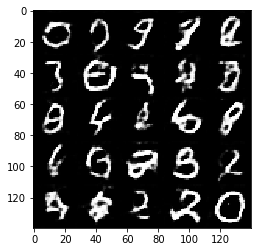

Epoch 2/2... Discriminator Loss: 0.6146... Generator Loss: 1.4008
Epoch 2/2... Discriminator Loss: 0.6018... Generator Loss: 1.5702
Epoch 2/2... Discriminator Loss: 0.7700... Generator Loss: 1.0740
Epoch 2/2... Discriminator Loss: 0.7427... Generator Loss: 0.9349
Epoch 2/2... Discriminator Loss: 0.6162... Generator Loss: 2.1105
Epoch 2/2... Discriminator Loss: 0.7130... Generator Loss: 1.8131
Epoch 2/2... Discriminator Loss: 0.8734... Generator Loss: 0.7250
Epoch 2/2... Discriminator Loss: 1.0446... Generator Loss: 0.6316
Epoch 2/2... Discriminator Loss: 0.6194... Generator Loss: 1.4213
Epoch 2/2... Discriminator Loss: 0.6387... Generator Loss: 1.6849


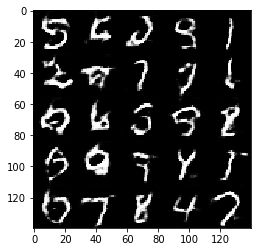

Epoch 2/2... Discriminator Loss: 0.5683... Generator Loss: 1.3342
Epoch 2/2... Discriminator Loss: 0.8002... Generator Loss: 0.9740
Epoch 2/2... Discriminator Loss: 0.7167... Generator Loss: 0.9580
Epoch 2/2... Discriminator Loss: 0.4966... Generator Loss: 2.1362
Epoch 2/2... Discriminator Loss: 0.8697... Generator Loss: 0.7252
Epoch 2/2... Discriminator Loss: 0.7125... Generator Loss: 0.9732
Epoch 2/2... Discriminator Loss: 0.6132... Generator Loss: 2.2281
Epoch 2/2... Discriminator Loss: 0.7240... Generator Loss: 0.9791
Epoch 2/2... Discriminator Loss: 0.6091... Generator Loss: 1.5957
Epoch 2/2... Discriminator Loss: 0.8981... Generator Loss: 2.9246


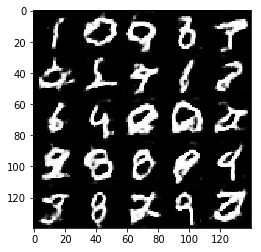

Epoch 2/2... Discriminator Loss: 1.2829... Generator Loss: 0.4294
Epoch 2/2... Discriminator Loss: 0.6021... Generator Loss: 1.3776
Epoch 2/2... Discriminator Loss: 0.7020... Generator Loss: 1.1173
Epoch 2/2... Discriminator Loss: 0.5580... Generator Loss: 1.2236
Epoch 2/2... Discriminator Loss: 0.8099... Generator Loss: 0.8248
Epoch 2/2... Discriminator Loss: 0.8330... Generator Loss: 0.7873
Epoch 2/2... Discriminator Loss: 0.7528... Generator Loss: 0.8589
Epoch 2/2... Discriminator Loss: 0.6887... Generator Loss: 1.0174
Epoch 2/2... Discriminator Loss: 1.1478... Generator Loss: 0.5381
Epoch 2/2... Discriminator Loss: 0.9187... Generator Loss: 0.7360


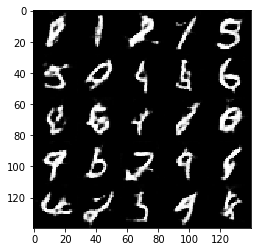

Epoch 2/2... Discriminator Loss: 1.0081... Generator Loss: 0.6851
Epoch 2/2... Discriminator Loss: 0.7422... Generator Loss: 0.9636
Epoch 2/2... Discriminator Loss: 0.5022... Generator Loss: 1.3171
Epoch 2/2... Discriminator Loss: 0.5644... Generator Loss: 1.4518
Epoch 2/2... Discriminator Loss: 0.5645... Generator Loss: 1.4059
Epoch 2/2... Discriminator Loss: 0.5916... Generator Loss: 1.4972
Epoch 2/2... Discriminator Loss: 0.6307... Generator Loss: 1.2768
Epoch 2/2... Discriminator Loss: 0.5015... Generator Loss: 1.3883
Epoch 2/2... Discriminator Loss: 0.7783... Generator Loss: 0.8685
Epoch 2/2... Discriminator Loss: 0.5478... Generator Loss: 1.9550


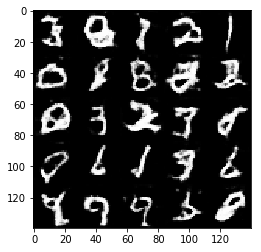

Epoch 2/2... Discriminator Loss: 0.7194... Generator Loss: 1.1398
Epoch 2/2... Discriminator Loss: 0.5605... Generator Loss: 1.2543
Epoch 2/2... Discriminator Loss: 0.9416... Generator Loss: 0.6805
Epoch 2/2... Discriminator Loss: 0.6568... Generator Loss: 1.1464
Epoch 2/2... Discriminator Loss: 0.5737... Generator Loss: 2.3088
Epoch 2/2... Discriminator Loss: 0.6808... Generator Loss: 1.0389
Epoch 2/2... Discriminator Loss: 0.6304... Generator Loss: 1.1574
Epoch 2/2... Discriminator Loss: 0.5224... Generator Loss: 1.5649
Epoch 2/2... Discriminator Loss: 0.6620... Generator Loss: 0.9644
Epoch 2/2... Discriminator Loss: 0.8563... Generator Loss: 0.7539


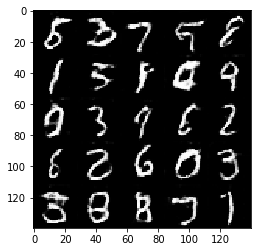

Epoch 2/2... Discriminator Loss: 0.7928... Generator Loss: 0.8706
Epoch 2/2... Discriminator Loss: 0.7514... Generator Loss: 0.8706
Epoch 2/2... Discriminator Loss: 0.8927... Generator Loss: 1.0126
Epoch 2/2... Discriminator Loss: 0.6479... Generator Loss: 1.3072
Epoch 2/2... Discriminator Loss: 0.5238... Generator Loss: 1.4282
Epoch 2/2... Discriminator Loss: 0.5451... Generator Loss: 1.7089
Epoch 2/2... Discriminator Loss: 0.6761... Generator Loss: 1.3281
Epoch 2/2... Discriminator Loss: 0.7061... Generator Loss: 0.9997
Epoch 2/2... Discriminator Loss: 0.3995... Generator Loss: 1.6174
Epoch 2/2... Discriminator Loss: 1.2531... Generator Loss: 0.5159


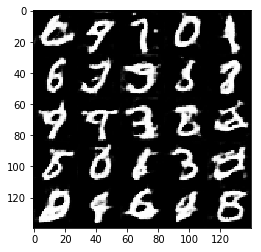

Epoch 2/2... Discriminator Loss: 0.6273... Generator Loss: 1.2314
Epoch 2/2... Discriminator Loss: 0.8248... Generator Loss: 1.0180
Epoch 2/2... Discriminator Loss: 0.9466... Generator Loss: 0.7114
Epoch 2/2... Discriminator Loss: 0.6301... Generator Loss: 1.3100
Epoch 2/2... Discriminator Loss: 0.5473... Generator Loss: 1.8008
Epoch 2/2... Discriminator Loss: 0.5824... Generator Loss: 1.3312
Epoch 2/2... Discriminator Loss: 0.5514... Generator Loss: 1.4113


In [51]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 0.6939... Generator Loss: 0.9190
Epoch 1/1... Discriminator Loss: 0.5595... Generator Loss: 1.4514
Epoch 1/1... Discriminator Loss: 0.8008... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.5546
Epoch 1/1... Discriminator Loss: 1.5979... Generator Loss: 0.4229
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.5570
Epoch 1/1... Discriminator Loss: 0.6977... Generator Loss: 1.4071
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.5332
Epoch 1/1... Discriminator Loss: 1.0440... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.0178... Generator Loss: 0.9135


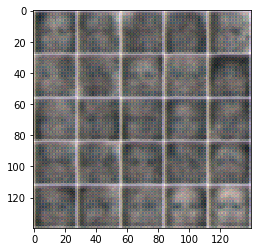

Epoch 1/1... Discriminator Loss: 1.0117... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 0.7808... Generator Loss: 1.1915
Epoch 1/1... Discriminator Loss: 0.6118... Generator Loss: 1.4269
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 0.9267... Generator Loss: 1.1887
Epoch 1/1... Discriminator Loss: 0.9645... Generator Loss: 1.1615
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.0060... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.5689
Epoch 1/1... Discriminator Loss: 0.7597... Generator Loss: 1.5483


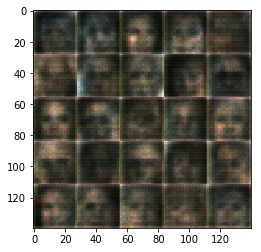

Epoch 1/1... Discriminator Loss: 0.8006... Generator Loss: 1.2037
Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 0.9151
Epoch 1/1... Discriminator Loss: 0.7590... Generator Loss: 0.9995
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.5222
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 1.8716
Epoch 1/1... Discriminator Loss: 0.8554... Generator Loss: 1.7286
Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.4277
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.9035
Epoch 1/1... Discriminator Loss: 1.9908... Generator Loss: 0.2405


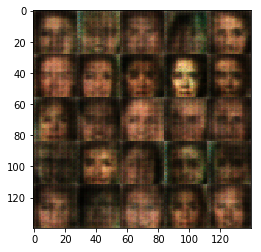

Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.5227
Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 0.9959... Generator Loss: 0.8647
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 1.4735
Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 0.9753
Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 1.6854
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 1.0697


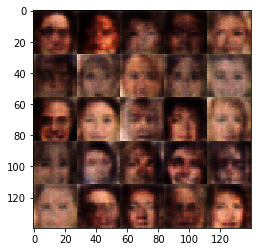

Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.5462
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 1.3955
Epoch 1/1... Discriminator Loss: 1.0097... Generator Loss: 1.0684
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.9968
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.4953
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.5091
Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 0.6397


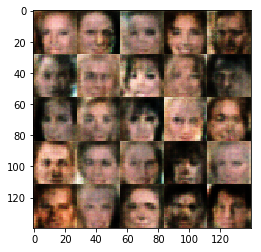

Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 1.3784
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 1.0858
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.8899
Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 0.9914
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.0462... Generator Loss: 1.0241
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.5826
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.9176
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 1.2156


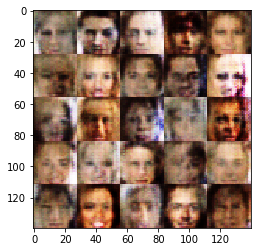

Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 0.9272... Generator Loss: 1.0035
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.5481
Epoch 1/1... Discriminator Loss: 0.9622... Generator Loss: 1.0932
Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 1.1674
Epoch 1/1... Discriminator Loss: 0.9969... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.5667
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 0.8775


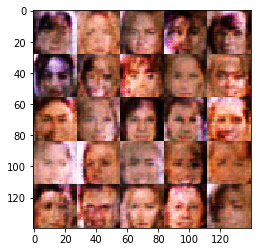

Epoch 1/1... Discriminator Loss: 1.1132... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 0.9517... Generator Loss: 1.1428
Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 0.8974... Generator Loss: 1.0863
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 0.9910... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 1.0670... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 0.9241... Generator Loss: 0.9707
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.7617


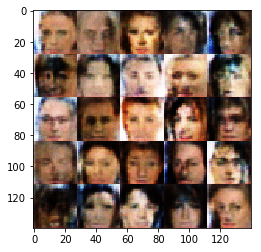

Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 0.5499
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 0.9417
Epoch 1/1... Discriminator Loss: 0.8312... Generator Loss: 1.0774
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.6435
Epoch 1/1... Discriminator Loss: 0.9692... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 0.9347... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 0.9500... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 1.0670
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.5437


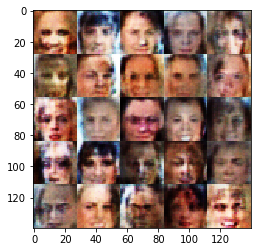

Epoch 1/1... Discriminator Loss: 0.9866... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 0.9264... Generator Loss: 1.0404
Epoch 1/1... Discriminator Loss: 1.0373... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 0.9276... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 0.5479
Epoch 1/1... Discriminator Loss: 1.0196... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 0.9587
Epoch 1/1... Discriminator Loss: 0.9463... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.7169


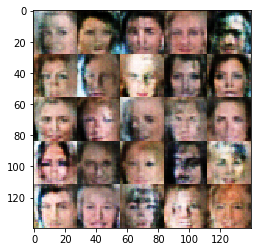

Epoch 1/1... Discriminator Loss: 1.0455... Generator Loss: 0.8665
Epoch 1/1... Discriminator Loss: 1.0615... Generator Loss: 0.9167
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 0.9989
Epoch 1/1... Discriminator Loss: 1.0299... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 0.9760... Generator Loss: 1.0372
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 1.3454
Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 0.8351


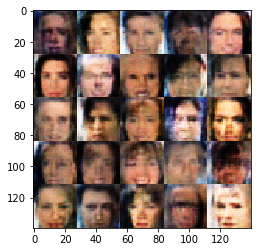

Epoch 1/1... Discriminator Loss: 0.9994... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 0.9813... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.5930
Epoch 1/1... Discriminator Loss: 0.8918... Generator Loss: 1.4603
Epoch 1/1... Discriminator Loss: 0.7904... Generator Loss: 1.0163
Epoch 1/1... Discriminator Loss: 1.0334... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 0.8894... Generator Loss: 1.0182


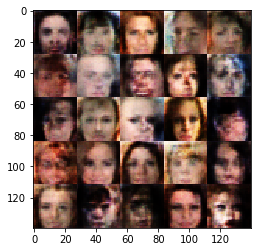

Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.4880
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 0.5255
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 0.5550
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 0.6309
Epoch 1/1... Discriminator Loss: 0.9304... Generator Loss: 0.9544
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.4836


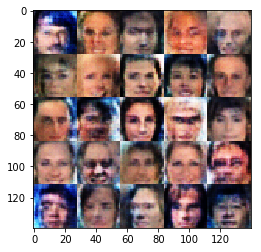

Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 0.5362
Epoch 1/1... Discriminator Loss: 1.0488... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.6153
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 0.5890
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 0.9057
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.4473
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 0.8204


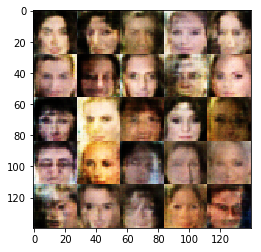

Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.5676
Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 0.9676... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 1.0257
Epoch 1/1... Discriminator Loss: 1.0030... Generator Loss: 1.1074
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.0346... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.4157
Epoch 1/1... Discriminator Loss: 0.8418... Generator Loss: 0.9893


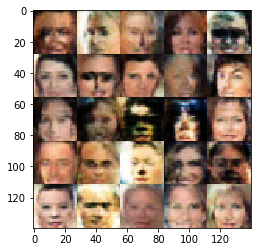

Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.0281... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.6607... Generator Loss: 0.3002
Epoch 1/1... Discriminator Loss: 0.9216... Generator Loss: 1.2273
Epoch 1/1... Discriminator Loss: 0.7716... Generator Loss: 1.2450
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 0.5659
Epoch 1/1... Discriminator Loss: 1.0001... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 0.8287
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.5646
Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 0.8065


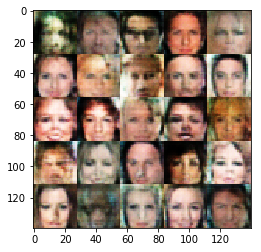

Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 0.8564... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 0.8911... Generator Loss: 1.1244
Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.5766
Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 0.9825... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 0.9435... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 0.6155


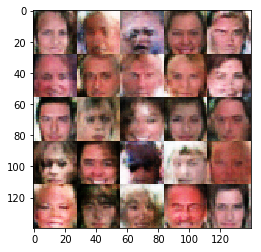

Epoch 1/1... Discriminator Loss: 0.9230... Generator Loss: 1.0686
Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 0.5361
Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 0.9221
Epoch 1/1... Discriminator Loss: 1.1004... Generator Loss: 0.9736
Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 0.9886... Generator Loss: 0.9164
Epoch 1/1... Discriminator Loss: 0.9327... Generator Loss: 1.0085
Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 0.6754


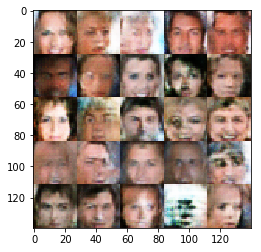

Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 0.9168
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 0.9543... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.4188
Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.5735
Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 0.5228
Epoch 1/1... Discriminator Loss: 0.8752... Generator Loss: 1.0291


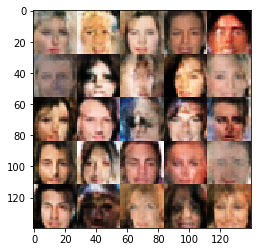

Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 0.5558
Epoch 1/1... Discriminator Loss: 0.9352... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.0589... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 0.6444... Generator Loss: 1.3966
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 0.7851... Generator Loss: 1.1241
Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 0.8431
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.0270... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 0.6489


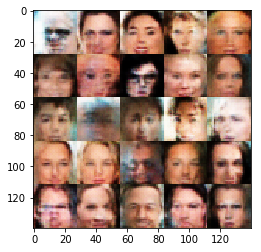

Epoch 1/1... Discriminator Loss: 0.9548... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 0.5457
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 0.9778... Generator Loss: 0.8818
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 0.8978
Epoch 1/1... Discriminator Loss: 1.1287... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 0.5830
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 0.6268


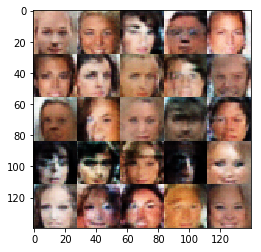

Epoch 1/1... Discriminator Loss: 0.8900... Generator Loss: 1.0763
Epoch 1/1... Discriminator Loss: 1.6371... Generator Loss: 0.6182
Epoch 1/1... Discriminator Loss: 0.9334... Generator Loss: 1.2225
Epoch 1/1... Discriminator Loss: 0.8937... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 0.9075... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.4115
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 0.8943... Generator Loss: 1.0633


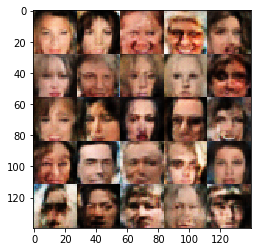

Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.4609
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 0.9064... Generator Loss: 0.9862
Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 0.6233
Epoch 1/1... Discriminator Loss: 1.0430... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.0464... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 0.9593... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.4792
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 0.5794
Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 0.8512


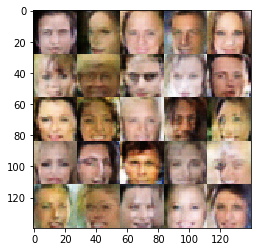

Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 0.9220
Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 0.9517
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 0.9119... Generator Loss: 1.1189
Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 0.9627
Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 1.0813... Generator Loss: 0.6310


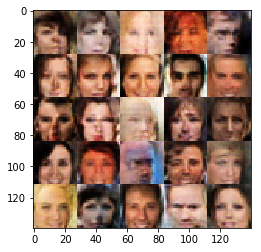

Epoch 1/1... Discriminator Loss: 1.0303... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.5806
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 0.9313
Epoch 1/1... Discriminator Loss: 0.7945... Generator Loss: 1.3477
Epoch 1/1... Discriminator Loss: 1.1351... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 1.0534
Epoch 1/1... Discriminator Loss: 0.9298... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.4219


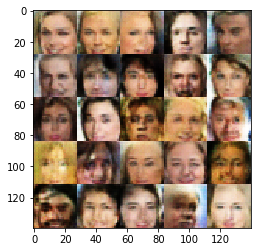

Epoch 1/1... Discriminator Loss: 1.0954... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 0.9299... Generator Loss: 0.8415
Epoch 1/1... Discriminator Loss: 1.5892... Generator Loss: 0.4483
Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.4718
Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 0.9713... Generator Loss: 0.9653
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 0.9230... Generator Loss: 0.7380


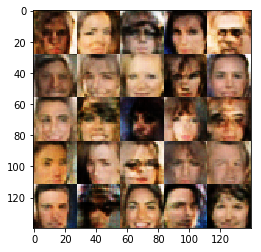

Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 0.9941... Generator Loss: 1.0968
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.0085... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 0.9277... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.0634... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 0.6402


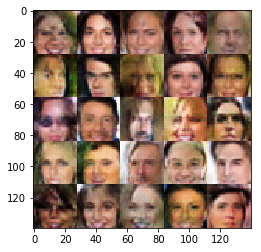

Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 0.9039
Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.4586
Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 0.9641
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 0.5600
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 0.8320... Generator Loss: 1.1515
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.5233
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.5760


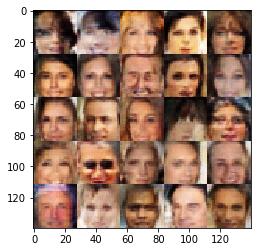

Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 0.9410
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.4851
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 0.6253
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.3697
Epoch 1/1... Discriminator Loss: 1.0019... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 0.9488
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.5897


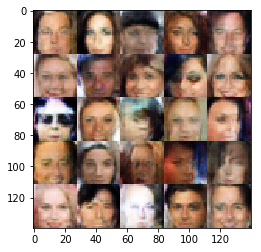

Epoch 1/1... Discriminator Loss: 1.0416... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 1.2276... Generator Loss: 0.5132
Epoch 1/1... Discriminator Loss: 1.0253... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.0433... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 0.9275
Epoch 1/1... Discriminator Loss: 0.8204... Generator Loss: 0.9690
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 0.7726


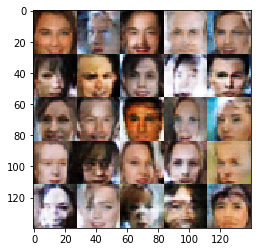

Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 1.2414
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.5996
Epoch 1/1... Discriminator Loss: 0.8855... Generator Loss: 0.8877
Epoch 1/1... Discriminator Loss: 1.1265... Generator Loss: 1.0128
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.5024
Epoch 1/1... Discriminator Loss: 0.9718... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 0.9436... Generator Loss: 1.2602
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 0.9579... Generator Loss: 0.9277


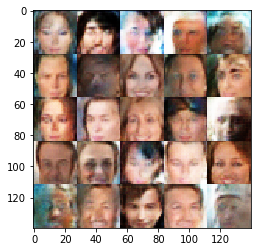

Epoch 1/1... Discriminator Loss: 0.9185... Generator Loss: 0.9668
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.6052
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.5246
Epoch 1/1... Discriminator Loss: 0.9372... Generator Loss: 0.9835
Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 1.0741... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 0.8519... Generator Loss: 0.9051
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 0.5686
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 0.8349


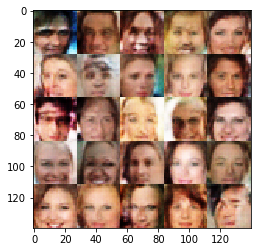

Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.5463
Epoch 1/1... Discriminator Loss: 1.0619... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 1.2396
Epoch 1/1... Discriminator Loss: 1.0489... Generator Loss: 0.9855
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.4606
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 0.7773... Generator Loss: 1.1438
Epoch 1/1... Discriminator Loss: 1.0315... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.0721... Generator Loss: 0.7564


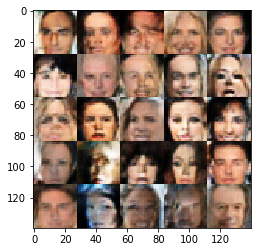

Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 0.8691... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 0.8271... Generator Loss: 1.0240
Epoch 1/1... Discriminator Loss: 0.8454... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.5490... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.4821
Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 0.7594


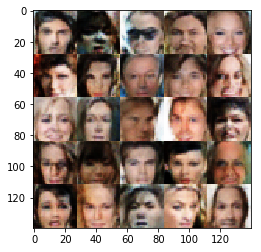

Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.4964
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 0.9505... Generator Loss: 1.0661
Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 1.2537
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 0.9233... Generator Loss: 0.9544
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.0147... Generator Loss: 0.9546
Epoch 1/1... Discriminator Loss: 0.8821... Generator Loss: 1.4547
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.7840


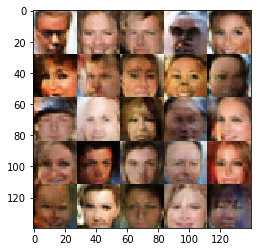

Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 0.9458
Epoch 1/1... Discriminator Loss: 0.9146... Generator Loss: 0.8474
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.4914
Epoch 1/1... Discriminator Loss: 1.0013... Generator Loss: 0.9316
Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 0.4708
Epoch 1/1... Discriminator Loss: 1.0949... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 0.9921... Generator Loss: 1.0420


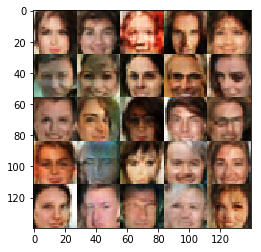

Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 0.9686
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.0159... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.4240
Epoch 1/1... Discriminator Loss: 1.0923... Generator Loss: 0.6041
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 0.5555
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 0.6130


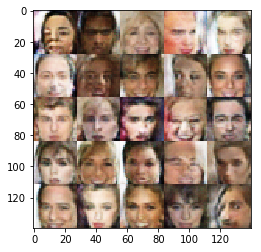

Epoch 1/1... Discriminator Loss: 0.9913... Generator Loss: 1.0662
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 1.0372... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.4654
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 0.5249
Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 1.0904
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 1.0082... Generator Loss: 0.6810


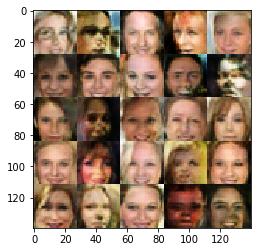

Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.6101
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 0.9725... Generator Loss: 0.9106
Epoch 1/1... Discriminator Loss: 1.0167... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 0.9227


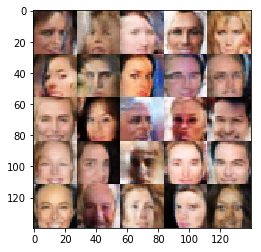

Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 0.5688
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.5280
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 0.8621... Generator Loss: 0.9239
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 0.9763... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 0.9931
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 0.6680


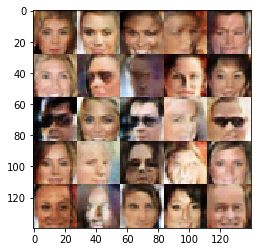

Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 0.9965... Generator Loss: 1.1849
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 0.9268... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 0.8456... Generator Loss: 0.8880
Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.6069
Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 0.8870
Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 0.5511


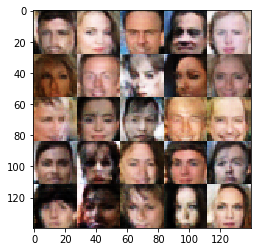

Epoch 1/1... Discriminator Loss: 1.0942... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.5476
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 1.0209... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.4639
Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 0.8539... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 0.9533... Generator Loss: 0.8379
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.5221
Epoch 1/1... Discriminator Loss: 1.0419... Generator Loss: 0.8271


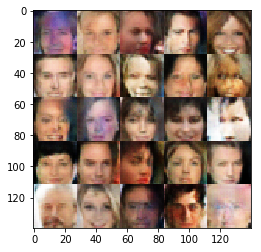

Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.4615
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.5450
Epoch 1/1... Discriminator Loss: 0.9966... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 0.9823... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 0.7172


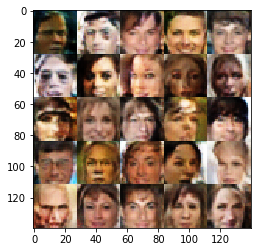

Epoch 1/1... Discriminator Loss: 1.2291... Generator Loss: 0.5410
Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 0.6405
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.4674
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 0.5370
Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.2790... Generator Loss: 0.5579
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.5892
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 0.9888... Generator Loss: 0.8597
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 0.7157


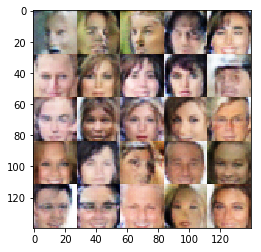

Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.4833
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 0.9746... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.5272
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.1594... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.4499
Epoch 1/1... Discriminator Loss: 0.8385... Generator Loss: 0.9254
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.5163
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.5204


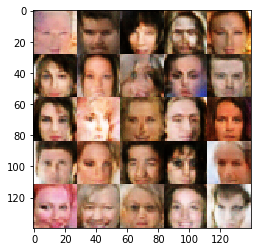

Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.0821... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 0.8372... Generator Loss: 1.0079
Epoch 1/1... Discriminator Loss: 0.8184... Generator Loss: 0.9339
Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.6853


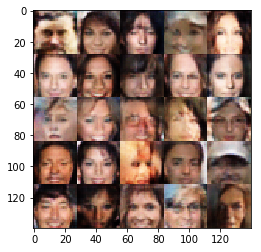

Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 0.9580
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 0.9138
Epoch 1/1... Discriminator Loss: 0.9109... Generator Loss: 0.9671
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.4167
Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 0.5724
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.5572
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.5749
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 0.5690
Epoch 1/1... Discriminator Loss: 0.9150... Generator Loss: 0.8734


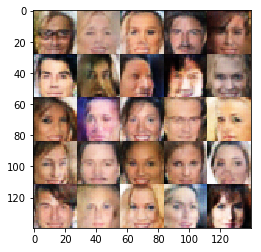

Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 1.0066
Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.4786
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.5140
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.4185
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 0.9079
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 0.5423


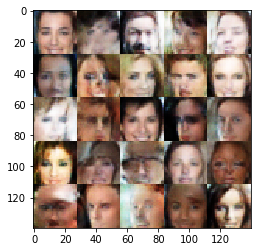

Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.4870
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.5200
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 1.1010... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.5727
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 0.5925


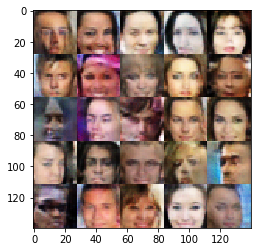

Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.4763
Epoch 1/1... Discriminator Loss: 1.1730... Generator Loss: 1.5963
Epoch 1/1... Discriminator Loss: 0.8731... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 1.2437... Generator Loss: 0.5502
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 0.5357
Epoch 1/1... Discriminator Loss: 1.0030... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.5452
Epoch 1/1... Discriminator Loss: 0.9693... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.9288


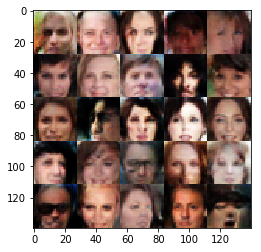

Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 1.1060
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.5286
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.1129... Generator Loss: 0.5898
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.7020


In [52]:
batch_size = 40
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。